#### Imports

In [7]:
# from datasets import load_dataset
from zipfile import ZipFile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Bidirectional, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
import random
from PIL import Image
import os

#### Directories

In [8]:
ROOT_DIR = os.getcwd()
DATASET_DIR = os.path.join('./dataset')
TRAIN_DIR  =os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'test')
TRAIN_METADATA_PATH = os.path.join(TRAIN_DIR, 'metadata.jsonl')
VAL_METADATA_PATH = os.path.join(VAL_DIR, 'metadata.jsonl')
TRAINED_MODEL_PATH = os.path.join('.\\trained_models')

In [9]:
print(len(os.listdir(TRAIN_DIR)))
print(len(os.listdir(VAL_DIR)))

33627
18705


#### Params

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
BUFFER_SIZE = 1000
LEARNING_RATE = 0.001

In [11]:
import json

def load_json_data(file_path):
    image_data = []
    text_data = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data = json.loads(line.strip())
                image_data.append(data['file_name'])
                text_data.append(data['text'])
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    
    return image_data, text_data

#### Preprocessing Images

In [12]:
def preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])  # Ensure the shape is defined
    image = tf.image.resize(image, target_size)
    # image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.int32)
    return image

def load_images_as_tensor(data_json, image_size, subset):
    dataset = tf.data.Dataset.from_tensor_slices(data_json)
 
    if subset == "train":
        preprocess_fn = lambda img: preprocess_image(
            tf.strings.join([TRAIN_DIR, img], separator=os.path.sep), image_size
        )
    else:
        preprocess_fn = lambda img: preprocess_image(
            tf.strings.join([VAL_DIR, img], separator=os.path.sep), image_size
        )

    dataset = dataset.map(
        preprocess_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return dataset

In [13]:
train_image_data, train_text_data = load_json_data(TRAIN_METADATA_PATH)
val_image_data, val_text_data = load_json_data(VAL_METADATA_PATH)

#### Vectorizer Settings

In [14]:
char_set = ['[START]', '[END]'] + list('0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,!?@$&()[]{}:;/- ')
max_len_text = max(val_text_data, key=len)
max_len = len(max_len_text)

vocab_size = len(char_set) + 2

print(f"Text with maximum length: {max_len_text}")
print(f"Maximum raw text length: {max_len}")

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize="lower",
    split='character',
    output_sequence_length=max_len,
    vocabulary=char_set
)

Text with maximum length: NO REFUNDS OR EXCHANGES WILL BE ENTERTAINED WITHOUT PROOF OF RECEIPT.
Maximum raw text length: 69


#### Preprocessing Texts

In [15]:
def preprocess_text(text, vectorizer):
    tokenized_text = tf.strings.join(['[START]', text, '[END]'])
    vectorized_text = vectorizer(tokenized_text)
    return vectorized_text

def vector_to_text(vectorized_text, vectorizer):
    vocab = vectorizer.get_vocabulary()
    decoded_text = [vocab[i] for i in vectorized_text if i != 0]
    return ''.join(decoded_text)

def load_text_to_tensor(data_text_json, vectorizer):
    dataset = tf.data.Dataset.from_tensor_slices(data_text_json)
    dataset = dataset.map(
        lambda text: preprocess_text(text, vectorizer),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset

#### Creating The Dataset

In [16]:
def load_dataset(data_path, subset, image_size, vectorizer, num_samples=None):
    images, texts = load_json_data(data_path)
    images_t = load_images_as_tensor(images, image_size, subset)
    texts_t = load_text_to_tensor(texts, vectorizer)
    num_samples = len(images) if num_samples is None else num_samples
    
    dataset = tf.data.Dataset.zip((images_t, texts_t))
    buffer_size = int(0.1 * len(images))
    dataset = (
        dataset
        .cache()
        .shuffle(buffer_size=buffer_size)
        .take(num_samples)
        .batch(batch_size=BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return dataset

In [17]:
train_ds = load_dataset(TRAIN_METADATA_PATH, "train", IMAGE_SIZE, vectorizer, 1000)
val_ds = load_dataset(VAL_METADATA_PATH, "val", IMAGE_SIZE, vectorizer, 100)

In [18]:
for image, text in train_ds.take(1):
    print(f"image shape: {image.shape}")
    print(text[1])
    print(f"text shape: {text.shape}")

image shape: (32, 256, 256, 3)
tf.Tensor(
[75 32 33 14 31 33 76 33 21 14 27 24 83 38 28 34 83 68 83 29 25 18 14 32
 18 83 16 28 26 18 83 14 20 14 22 27 83 68 75 18 27 17 76  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(69,), dtype=int64)
text shape: (32, 69)


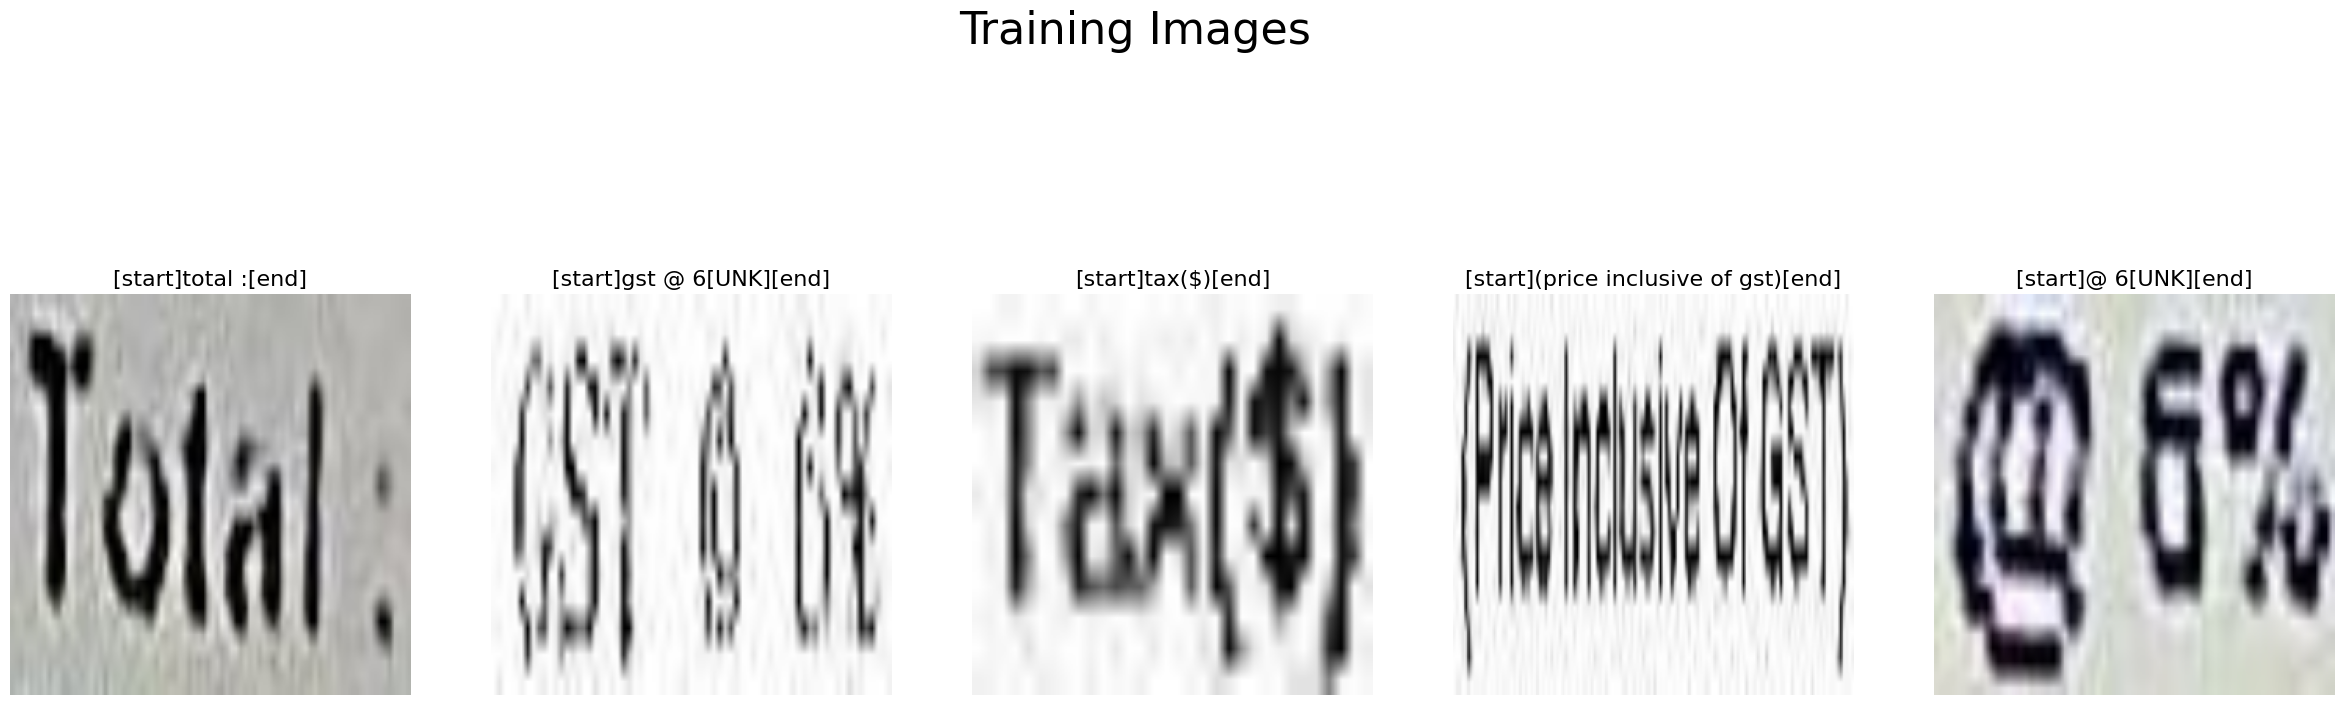

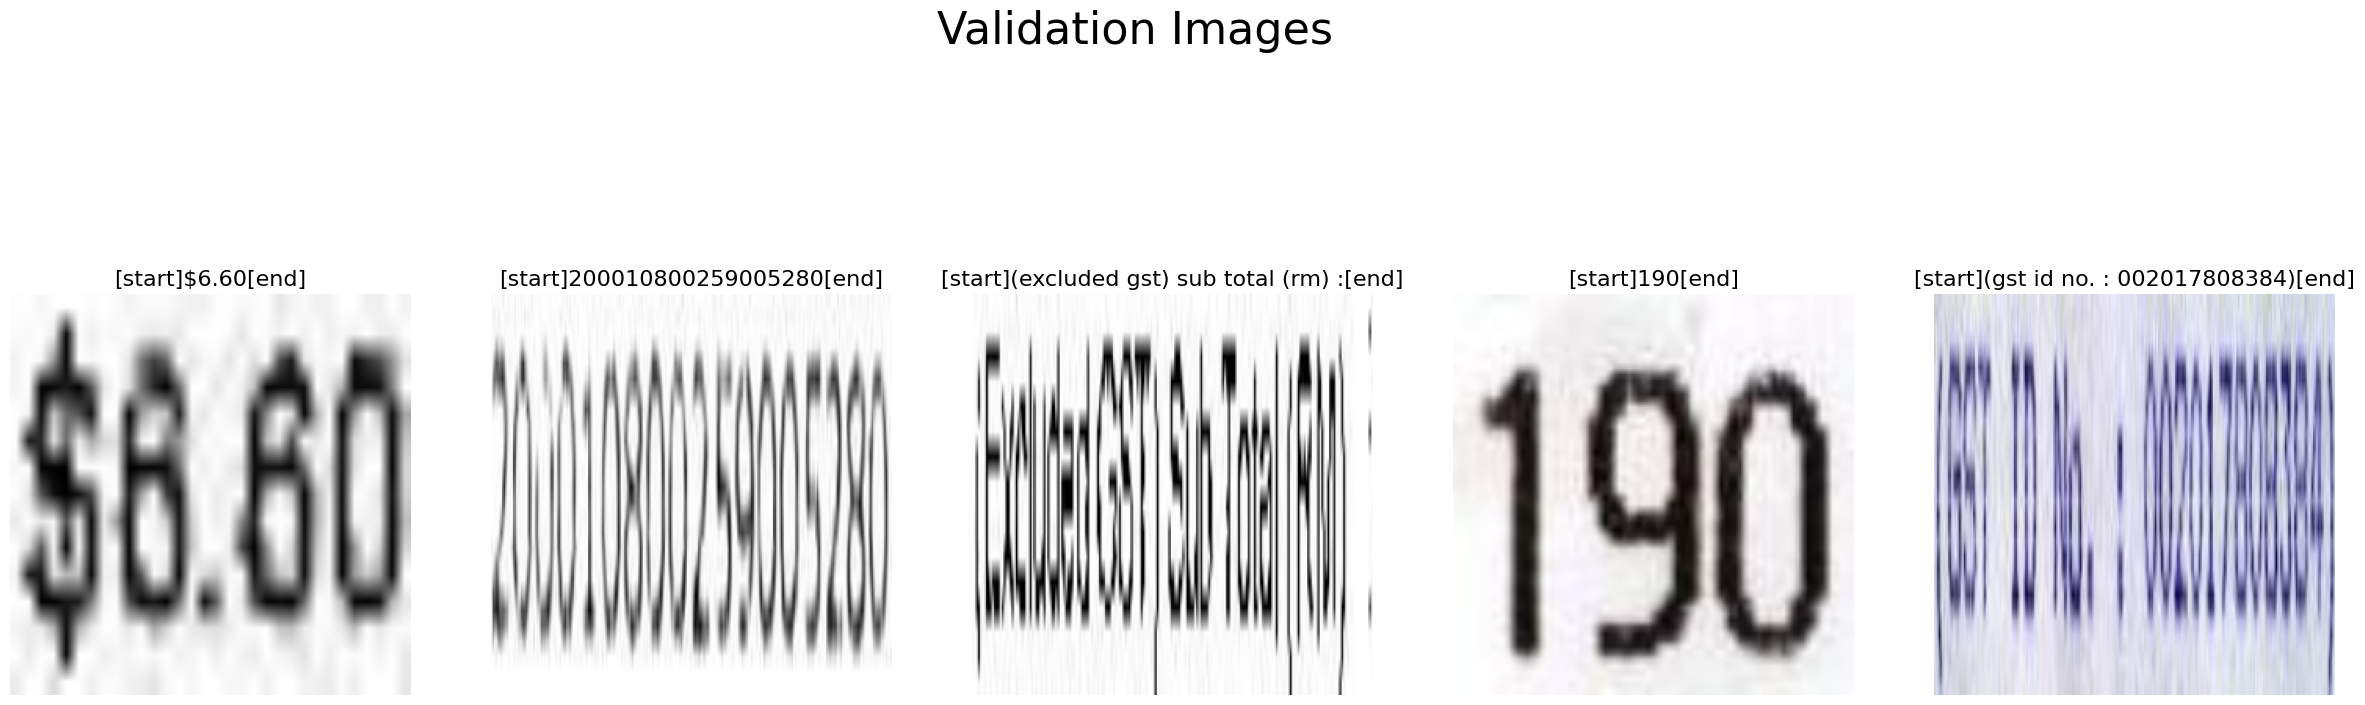

In [19]:
import matplotlib.pyplot as plt

def plot_images_with_titles(dataset, num_images, vectorizer, title="Images", figsize=(30, 10)):
    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    for idx, (image, text) in enumerate(dataset.take(1)):
        if idx >= num_images:
            break

        for i in range(min(num_images, image.shape[0])):  
            single_img = image[i]  
            single_text = text[i]  
            title_text = vector_to_text(single_text, vectorizer) 
            axes[i].imshow(single_img.numpy().squeeze())
            axes[i].set_title(title_text, fontsize=16) 
            axes[i].axis('off')

    plt.suptitle(title, fontsize=32)
    plt.show()


plot_images_with_titles(train_ds, num_images=5, vectorizer=vectorizer, title="Training Images")
plot_images_with_titles(val_ds, num_images=5, vectorizer=vectorizer, title="Validation Images")

#### Creating Model

In [20]:
def load_crnn_model(input_dim, output_dim):
    inputs = Input(shape=input_dim, name="input")
    input_normalized = Lambda(lambda x: x / 255.0)(inputs)
    
    resnet = ResNet50(include_top=False, weights="imagenet", input_shape=input_dim)
    for layer in resnet.layers:
        layer.trainable = False

    backbone = Model(inputs=resnet.input, outputs=resnet.get_layer('conv4_block6_out').output)
    cnn_output = backbone(input_normalized)

    cnn_output_shape = cnn_output.shape
    reshaped_output = Reshape((cnn_output_shape[-3] * cnn_output_shape[-2], cnn_output_shape[-1]))(cnn_output)

    # Add the RNN layers (Bidirectional LSTMs)
    blstm = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(reshaped_output)

    # Add the final classification layer
    output = Dense(output_dim, activation="softmax", name="output")(blstm)

    # Create the model
    model = Model(inputs=inputs, outputs=output)
    return model

In [21]:
#resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

#esnet.summary()

#### Training the model

In [22]:
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.metrics import CWERMetric
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard


model = load_crnn_model((256, 256, 3), vocab_size)
model.name = "CRNN_Model_control"

model.compile(
    optimizer=tf.keras.optimizers.Adam(clipnorm=1.0), 
    loss=CTCloss(), 
    metrics=[CWERMetric(padding_token=0)],
    run_eagerly=False
)

earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode='min')
checkpoint = ModelCheckpoint(f"{TRAINED_MODEL_PATH}/{model.name}/weight.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="max")
tb_callback = TensorBoard(f"{TRAINED_MODEL_PATH}/{model.name}/logs", update_freq=10)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto")

model.summary()

Model: "CRNN_Model_control"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 16, 16, 1024)   │     8,589,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256, 512)       │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 256, 84)        │        43,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,255,764 (42.94 MB)

 Trainable params: 2,666,580 (10.17 MB)

 Non-trainable params: 8,589,184 (32.77 MB)

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[earlystopper, checkpoint, reduceLROnPlat, tb_callback],
)

Epoch 1/100



RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InvalidArgumentError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tensorflow\python\framework\errors_impl.py(284): __init__
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tensorflow\python\eager\execute.py(53): quick_execute
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tensorflow\python\eager\context.py(1683): call_function
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py(251): call_flat
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py(216): call_preflattened
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tensorflow\python\eager\polymorphic_function\concrete_function.py(1322): _call_flat
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(919): _call
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(833): __call__
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tensorflow\python\util\traceback_utils.py(150): error_handler
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\keras\src\backend\tensorflow\trainer.py(320): fit
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\keras\src\utils\traceback_utils.py(117): error_handler
  C:\Users\NAN0C\AppData\Local\Temp\ipykernel_21128\1400884231.py(1): <module>
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\IPython\core\interactiveshell.py(3577): run_code
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\IPython\core\interactiveshell.py(3517): run_ast_nodes
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\IPython\core\interactiveshell.py(3334): run_cell_async
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\IPython\core\async_helpers.py(128): _pseudo_sync_runner
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\IPython\core\interactiveshell.py(3130): _run_cell
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\IPython\core\interactiveshell.py(3075): run_cell
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\ipykernel\zmqshell.py(549): run_cell
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\ipykernel\ipkernel.py(449): do_execute
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\ipykernel\kernelbase.py(778): execute_request
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\ipykernel\ipkernel.py(362): execute_request
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\ipykernel\kernelbase.py(437): dispatch_shell
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\ipykernel\kernelbase.py(534): process_one
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\ipykernel\kernelbase.py(545): dispatch_queue
  C:\Python311\Lib\asyncio\events.py(80): _run
  C:\Python311\Lib\asyncio\base_events.py(1922): _run_once
  C:\Python311\Lib\asyncio\base_events.py(607): run_forever
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\tornado\platform\asyncio.py(205): start
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\ipykernel\kernelapp.py(739): start
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\traitlets\config\application.py(1075): launch_instance
  c:\Users\NAN0C\.virtualenvs\Receipt_OCR_Model-IXa-la9e\Lib\site-packages\ipykernel_launcher.py(18): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


In [ ]:
train_cer = history.history['CER']
val_cer = history.history['val_CER']
epochs = list(reversed(range(1, len(train_cer) + 1)))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_cer, label='Training CER', marker='o')
plt.plot(epochs, val_cer, label='Validation CER', marker='o')
plt.title('Training and Validation CER')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = list(reversed(range(1, len(train_cer) + 1)))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_cer, label='Training Loss', marker='o')
plt.plot(epochs, val_cer, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
example_image = val_image_data[0]
image_path = os.path.join(VAL_DIR, example_image)
pre_image = preprocess_image(image_path, IMAGE_SIZE)
pre_image = tf.expand_dims(pre_image, axis=0)

text = model.predict(pre_image)

In [ ]:
def vectors_to_texts(vectorized_texts, vectorizer):
    vocab = vectorizer.get_vocabulary()
    
    decoded_texts = []
    for vectorized_text in vectorized_texts:
        decoded_text = [vocab[i] for i in vectorized_text if i != 0] 
        decoded_texts.append(''.join(decoded_text)) 
    
    return decoded_texts


normalized_text =(text).astype(int)
normalized_text = normalized_text.squeeze()
print(text)
print(vectors_to_texts(normalized_text, vectorizer))